In [1]:
# Implimentation of a language model from the following research paper:
# https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
VOCAB_SIZE = len(stoi.keys())
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
BLOCK_SIZE = 3  # Context length.  How many letters do we take to predict the next.

# Build a data set.
def build_dataset(words): 
    """Build a data set from the given data.
  
    Returns: 
      torch.tensor: X inputs (context block_size long)
      torch.tensor: Y labels
    """
    X, Y = [], []
  
    for w in words:
        context = [0] * BLOCK_SIZE
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# Going to split the training set.
n1 = int(0.8*len(words))  # 80% for training.
n2 = int(0.9*len(words))  # 10% for dev, and then 10% for eval.

import random
random.seed(42)
random.shuffle(words)
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# Copy-paste of the data types we build previously.

# The classes we create here are the same API as nn.Module in PyTorch
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta  = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar  = x.var( 0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [6]:
# Build the network
g = torch.Generator().manual_seed(2147483647) # for reproducibility
EMBED_SIZE = 10
NUM_HIDDEN_NEURONS = 100
L1_INPUT_SIZE = EMBED_SIZE * BLOCK_SIZE

C = torch.randn((VOCAB_SIZE, EMBED_SIZE),            generator=g)
layers = [
    # Layer 1: Input from embeddings.
    Linear(L1_INPUT_SIZE, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Layer 2
    Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Layer 3
    Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Layer 4
    Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Layer 5
    Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Output layer
    Linear(NUM_HIDDEN_NEURONS, VOCAB_SIZE, bias=False),
    BatchNorm1d(VOCAB_SIZE),
]
with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("Total params: ", sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

Total params:  47024


In [7]:
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 15000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())

print(loss.item())

      0/  20000: 3.2870
   1000/  20000: 2.2807
   2000/  20000: 2.6592
   3000/  20000: 2.4179
   4000/  20000: 2.0728
   5000/  20000: 1.9455
   6000/  20000: 2.1830
   7000/  20000: 2.2762
   8000/  20000: 2.2768
   9000/  20000: 2.2899
  10000/  20000: 2.3273
  11000/  20000: 2.4599
  12000/  20000: 2.5290
  13000/  20000: 1.8646
  14000/  20000: 2.6447
  15000/  20000: 2.0133
  16000/  20000: 1.9743
  17000/  20000: 2.4100
  18000/  20000: 2.2002
  19000/  20000: 2.4772
2.0607450008392334


In [8]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    """Simple function to take a split of the data and compute the loss.  No
    gradients will be calculated."""
    x,y = {
        'train': (Xtr,  Ytr),
        'val'  : (Xdev, Ydev),
        'test' : (Xte,  Yte),
    }[split]
    # forward pass
    emb = C[x] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y) # loss function
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1310999393463135
val 2.152378797531128


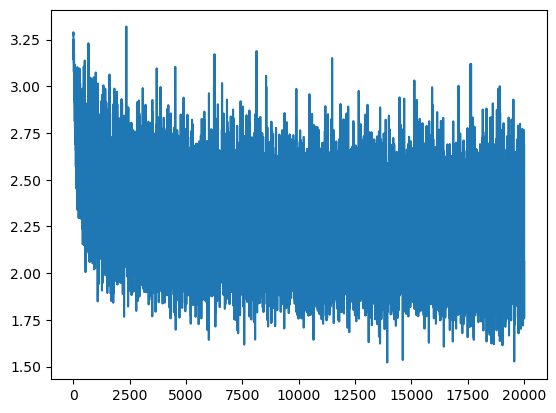

In [9]:
plt.plot(lossi)

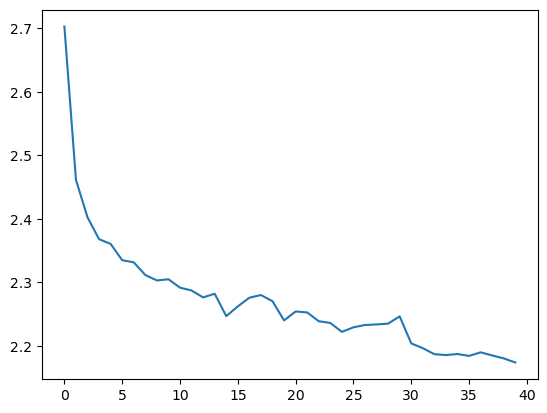

In [10]:
plt.plot(torch.tensor(lossi).view(-1, 500).mean(1))

In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for layer in layers:
   layer.training = False

for _ in range(20):
    
    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmah.
amelle.
khi.
mili.
taty.
skaassie.
mahnel.
deliah.
jareen.
nellara.
chaiiv.
kaleigh.
ham.
join.
quinn.
shon.
malianni.
watthoniearyxi.
jace.
pilra.


We currently have too many steps in our forward pass.  The embedding step is outside of our layers, and the flattening after getting the embeddings is a separate step.  We need to make special types to perform those functions.

In [12]:
# We will name the classes the same way they are named in torch.
class Embedding:
    def __init__(self, num_embeddings, embedding_dimensions):
        """Inputs:
            num_embeddings:       Normally the total vocab size.
            embedding_dimensions: The size of the embedding dimensional space.
        """
        self.weight = torch.randn((num_embeddings, embedding_dimensions))
    
    def __call__(self, IX):
        self.out = self.weight[IX]  # Perform the embedding, ie fetch the embedding vector for every input.
        return self.out
    
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        """Keep the first dimention, and let torch figure out how to arrange all the other
        dimensions to make a 2-D matrix.
        """
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    """Class to hold a list of layers that should be called in sequence."""
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [13]:
# We can rebuild the network as pure layers.
g = torch.Generator().manual_seed(42) # for reproducibility
EMBED_SIZE = 10
NUM_HIDDEN_NEURONS = 100
L1_INPUT_SIZE = EMBED_SIZE * BLOCK_SIZE

model = Sequential([
    # Layer 0: Embeddings.
    Embedding(VOCAB_SIZE, EMBED_SIZE),
    # Layer 0b: Flatten to an input to the hidden layers.
    Flatten(),
    # Layer 1: Input from embeddings.
    Linear(L1_INPUT_SIZE, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Layer 2
    Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Layer 3
    Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Layer 4
    Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Layer 5
    Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Output layer
    Linear(NUM_HIDDEN_NEURONS, VOCAB_SIZE, bias=False),
    BatchNorm1d(VOCAB_SIZE),
])
with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].gamma *= 0.1

parameters = model.parameters()
print("Total params: ", sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


Total params:  47024


In [14]:
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 15000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())

print(loss.item())

      0/  20000: 3.3360
   1000/  20000: 2.6625
   2000/  20000: 2.4376
   3000/  20000: 2.3973
   4000/  20000: 1.7952
   5000/  20000: 2.4707
   6000/  20000: 2.3159
   7000/  20000: 2.1150
   8000/  20000: 2.3277
   9000/  20000: 2.4479
  10000/  20000: 2.1508
  11000/  20000: 2.4334
  12000/  20000: 2.0012
  13000/  20000: 1.9161
  14000/  20000: 2.4280
  15000/  20000: 2.0505
  16000/  20000: 1.6496
  17000/  20000: 2.2935
  18000/  20000: 1.8684
  19000/  20000: 2.4034
2.049808979034424


In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    """Simple function to take a split of the data and compute the loss.  No
    gradients will be calculated."""
    x,y = {
        'train': (Xtr,  Ytr),
        'val'  : (Xdev, Ydev),
        'test' : (Xte,  Yte),
    }[split]
    # forward pass
    logits = model(x)
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1319594383239746
val 2.1536943912506104


In [16]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for layer in model.layers:
   layer.training = False
   

for _ in range(20):
    
    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmahfamille.
khi.
mili.
taty.
skanden.
jazontefamerynci.
aqui.
nellara.
chaiiv.
kaleigh.
ham.
jock.
quinton.
lilea.
jadiquinterridearynix.
kael.
dura.
med.
emiia.
giley.


In [17]:
# Let's start experimenting as we start to implement WaveNet.
# https://arxiv.org/abs/1609.03499 

BLOCK_SIZE = 8  # Context length.  How many letters do we take to predict the next.

# Build a data set.
def build_dataset(words): 
    """Build a data set from the given data.
  
    Returns: 
      torch.tensor: X inputs (context block_size long)
      torch.tensor: Y labels
    """
    X, Y = [], []
  
    for w in words:
        context = [0] * BLOCK_SIZE
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# Going to split the training set.
n1 = int(0.8*len(words))  # 80% for training.
n2 = int(0.9*len(words))  # 10% for dev, and then 10% for eval.

import random
random.seed(42)
random.shuffle(words)
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [18]:
g = torch.Generator().manual_seed(42) # for reproducibility
EMBED_SIZE = 10
NUM_HIDDEN_NEURONS = 200
L1_INPUT_SIZE = EMBED_SIZE * BLOCK_SIZE

model = Sequential([
    # Layer 0: Embeddings.
    Embedding(VOCAB_SIZE, EMBED_SIZE),
    # Layer 0b: Flatten to an input to the hidden layers.
    Flatten(),
    # Layer 1: Input from embeddings.
    Linear(L1_INPUT_SIZE, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Output layer
    Linear(NUM_HIDDEN_NEURONS, VOCAB_SIZE, bias=False),
    BatchNorm1d(VOCAB_SIZE),
])
with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].gamma *= 0.1

parameters = model.parameters()
print("Total params: ", sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

Total params:  22124


In [19]:
max_steps = 20000
batch_size = 4
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 15000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())
    break

print(loss.item())

      0/  20000: 3.3130
3.312997817993164


In [20]:
model.layers[0].out.shape  # output of embedding layer

torch.Size([4, 8, 10])

In [21]:
model.layers[1].out.shape  # output of flatten layer

torch.Size([4, 80])

In [22]:
model.layers[2].out.shape  # output of linear layer

torch.Size([4, 200])

In [23]:
# Right now we're taking all 8 context chars and multiplying against the weights all at once.  
# But in the WaveNet, they take pairs of chars to apply to weights.  torch allows us to break apart
# leading dimensions.  It only cares about the final dimension for the multiply.  It treats all
# of the leading dimensions as batches, or groups.
print((torch.rand(4, 80) @ torch.randn(80, 200)).shape)
print((torch.rand(4, 6, 80) @ torch.randn(80, 200)).shape)

torch.Size([4, 200])
torch.Size([4, 6, 200])


In [24]:
# Our input is:
# 1 2 3 4 5 6 7 8
# Want
# (1 2) (3 4) (5 6) (7 8)
# So instead of 80, we would expect 4 by 20
print((torch.rand(4, 4, 20) @ torch.randn(20, 200)).shape)
# So we need to change our Flatten layer.
example = torch.randn(4, 8, 10)  # What we get from embedding
print(example.view(example.shape[0], -1).shape)  # This is what flattening currently does.
# We can index in the tensor by reading all of a dimension (:), every other (::2).
print(list(range(10))[::2])  # Sample for every-other list.
print("even: ", example[:, ::2, :].shape)
# That indexing gave the proper shape as output.  We also need the odd-index version:
print("odd : ", example[:, 1::2, :].shape)
# cat them together:
print("cat try1: ", torch.cat((example[:, ::2, :], example[:, 1::2, :])).shape)
# That looks wrong, because it combined the first dimension, not the second one.
print("cat try2: ", torch.cat((example[:, ::2, :], example[:, 1::2, :]), dim=2).shape)
# Looks correct!

torch.Size([4, 4, 200])
torch.Size([4, 80])
[0, 2, 4, 6, 8]
even:  torch.Size([4, 4, 10])
odd :  torch.Size([4, 4, 10])
cat try1:  torch.Size([8, 4, 10])
cat try2:  torch.Size([4, 4, 20])


In [25]:
# But torch can do this for us.  We can just tell view how we want to see it.
explicit = torch.cat((example[:, ::2, :], example[:, 1::2, :]), dim=2)
faster = example.view(4, 4, 20)
(explicit == faster).all()  # They should match.
# And they do.

tensor(True)

In [26]:
# We need to make a new layer type to do this more interesting flatten step.

class FlattenConsecutive:
    def __init__(self, num_consecutive_elements):
        self.n = num_consecutive_elements
    
    def __call__(self, x):
        """Keep the first dimension, and adjust the other dimensions according to the
        number of consecutive elements that should be grouped.

        The second dimension should get reduced by the number of consecutive elements we
        will group, and the last dimension will go up by that many elements.
        """
        B, T, C = x.shape  # Batch, Tokens, Embedding vector (called Channels by torch)
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:  # If the second dimension is just 1 element, get rid of it.
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

In [27]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
EMBED_SIZE = 10
GROUP_SIZE = 2
NUM_HIDDEN_NEURONS = 68
L1_INPUT_SIZE = EMBED_SIZE * GROUP_SIZE

model = Sequential([
    # Layer 0: Embeddings.
    Embedding(VOCAB_SIZE, EMBED_SIZE),
    
    # Layer 1: Input from embeddings.
    FlattenConsecutive(GROUP_SIZE),
    Linear(L1_INPUT_SIZE, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    
    # Layer 2: Hidden layer.
    FlattenConsecutive(GROUP_SIZE),
    Linear(NUM_HIDDEN_NEURONS * GROUP_SIZE, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    
    # Layer 2: Hidden layer.
    FlattenConsecutive(GROUP_SIZE),
    Linear(NUM_HIDDEN_NEURONS * GROUP_SIZE, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    
    # Output layer
    Linear(NUM_HIDDEN_NEURONS, VOCAB_SIZE, bias=False),
])
with torch.no_grad():
    # last layer: make less confident
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print("Total params: ", sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True


Total params:  22370


In [28]:
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 15000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())

print(loss.item())

      0/  20000: 3.3062
   1000/  20000: 2.3637
   2000/  20000: 2.0799
   3000/  20000: 2.4182
   4000/  20000: 2.0593
   5000/  20000: 2.2573
   6000/  20000: 2.6915
   7000/  20000: 2.6990
   8000/  20000: 2.1639
   9000/  20000: 1.8186
  10000/  20000: 2.6122
  11000/  20000: 2.0966
  12000/  20000: 2.0769
  13000/  20000: 2.3389
  14000/  20000: 2.3431
  15000/  20000: 2.4200
  16000/  20000: 2.0399
  17000/  20000: 2.0850
  18000/  20000: 2.0851
  19000/  20000: 2.0204
2.1082584857940674


In [29]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [30]:
# Let's debug the bachnorm layer a bit.

examp = torch.randn(32, 4, 68)  # Our input shape.
emean = examp.mean(0, keepdim=True)
evar  = examp.var( 0, keepdim=True)
ehat  = (examp - emean) / torch.sqrt(evar + 1e-5)
print(ehat.shape)
# Note that the shape has a middle dimension of 4.  So we are keeping 4 independant means and variences. 
# We don't want it spit up like this.  We want the mean and variance for all samples together.
# We need to update the torch.mean and var calls.  They can take a tuple of dimensions to calculate over.
emean = examp.mean((0, 1), keepdim=True)
evar  = examp.var( (0, 1), keepdim=True)
print(emean.shape)
# Note this is good.

torch.Size([32, 4, 68])
torch.Size([1, 1, 68])


In [31]:
# Let's rebuild the BatchNorm1d class to fix this issue.
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta  = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)  # Average over multiple dimensions.
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar  = x.var( dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

In [32]:
# Rebuild with our new type.
g = torch.Generator().manual_seed(2147483647) # for reproducibility
EMBED_SIZE = 10
GROUP_SIZE = 2
NUM_HIDDEN_NEURONS = 68
L1_INPUT_SIZE = EMBED_SIZE * GROUP_SIZE

model = Sequential([
    # Layer 0: Embeddings.
    Embedding(VOCAB_SIZE, EMBED_SIZE),
    
    # Layer 1: Input from embeddings.
    FlattenConsecutive(GROUP_SIZE),
    Linear(L1_INPUT_SIZE, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    
    # Layer 2: Hidden layer.
    FlattenConsecutive(GROUP_SIZE),
    Linear(NUM_HIDDEN_NEURONS * GROUP_SIZE, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    
    # Layer 2: Hidden layer.
    FlattenConsecutive(GROUP_SIZE),
    Linear(NUM_HIDDEN_NEURONS * GROUP_SIZE, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    
    # Output layer
    Linear(NUM_HIDDEN_NEURONS, VOCAB_SIZE, bias=False),
])
with torch.no_grad():
    # last layer: make less confident
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print("Total params: ", sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

Total params:  22370


In [33]:
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 15000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.item())

print(loss.item())
print(model.layers[3].running_mean.shape)

      0/  20000: 3.2965
   1000/  20000: 2.4132
   2000/  20000: 1.9985
   3000/  20000: 2.2158
   4000/  20000: 2.0901
   5000/  20000: 2.2129
   6000/  20000: 2.6442
   7000/  20000: 2.5397
   8000/  20000: 1.9940
   9000/  20000: 1.8370
  10000/  20000: 2.4955
  11000/  20000: 2.0929
  12000/  20000: 2.2284
  13000/  20000: 2.3509
  14000/  20000: 2.2161
  15000/  20000: 2.3734
  16000/  20000: 2.0721
  17000/  20000: 2.0861
  18000/  20000: 2.0556
  19000/  20000: 2.0253
2.0163474082946777
torch.Size([1, 1, 68])
